In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.random.set_seed(42)


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
dataset = pd.read_csv("Superstore.csv", sep=",", encoding='latin1')
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
print(dataset.dtypes)
print(dataset.describe())
dataset.isnull().sum()
dataset.duplicated().sum()
dataset.columns

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object
            Row ID   Postal Code         Sales     Quantity     Discount  \
count  9994.000000   9994.000000   9994.000000  9994.000000  9994.000000   
mean   4997.500000  55190.379428    229.858001     3.789574     0.156203   
std    2885.163629  32063.693350    623.245101     2.225110     0.206452   
min       1.000000   1040.000000      0.444000     1.000000     0.000000   
25%    2499.250000  23223.000000     17.280000     2.000000     0.000000   
50%  

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [ ]:
for col in dataset.columns:
    unique_values = dataset[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values")

Column 'Row ID' has 9994 unique values
Column 'Order ID' has 5009 unique values
Column 'Order Date' has 1237 unique values
Column 'Ship Date' has 1334 unique values
Column 'Ship Mode' has 4 unique values
Column 'Customer ID' has 793 unique values
Column 'Customer Name' has 793 unique values
Column 'Segment' has 3 unique values
Column 'Country' has 1 unique values
Column 'City' has 531 unique values
Column 'State' has 49 unique values
Column 'Postal Code' has 631 unique values
Column 'Region' has 4 unique values
Column 'Product ID' has 1862 unique values
Column 'Category' has 3 unique values
Column 'Sub-Category' has 17 unique values
Column 'Product Name' has 1850 unique values
Column 'Sales' has 5825 unique values
Column 'Quantity' has 14 unique values
Column 'Discount' has 12 unique values
Column 'Profit' has 7287 unique values


In [ ]:
dataset = dataset.drop(columns=['Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Product ID'], axis=1).reset_index(drop=True)


In [ ]:
for col in dataset.columns:
    if dataset[col].dtype in ['float64', 'int64']:
        unique_values = dataset[col].unique()
        print(f"Column '{col}' has {len(unique_values)} unique values")

Column 'Postal Code' has 631 unique values
Column 'Sales' has 5825 unique values
Column 'Quantity' has 14 unique values
Column 'Discount' has 12 unique values
Column 'Profit' has 7287 unique values


In [ ]:
numerical_cols = ['Sales' ,'Postal Code','Profit']

#Calculate Q1, Q3, and IQR for the numerical columns
Q1 = dataset[numerical_cols].quantile(0.25)
Q3 = dataset[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_no_outliers = dataset[~((dataset[numerical_cols] < lower_bound) | (dataset[numerical_cols] > upper_bound)).any(axis=1)].copy()
df_no_outliers

,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,11/8/2016,11/11/2016,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
2,6/12/2016,6/16/2016,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,10/11/2015,10/18/2015,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
5,6/9/2014,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,7,0.0,14.1694
6,6/9/2014,6/14/2014,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,11/17/2017,11/21/2017,Standard Class,Corporate,United States,Athens,Georgia,30605,South,Technology,Phones,Panasonic KX - TS880B Telephone,206.100,5,0.0,55.6470
9989,1/21/2014,1/23/2014,Second Class,Consumer,United States,Miami,Florida,33180,South,Furniture,Furnishings,Ultra Door Pull Handle,25.248,3,0.2,4.1028
9990,2/26/2017,3/3/2017,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.960,2,0.0,15.6332
9991,2/26/2017,3/3/2017,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Technology,Phones,Aastra 57i VoIP phone,258.576,2,0.2,19.3932


<class 'pandas.core.frame.DataFrame'>
Index: 7874 entries, 0 to 9992
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order Date    7874 non-null   object 
 1   Ship Date     7874 non-null   object 
 2   Ship Mode     7874 non-null   object 
 3   Segment       7874 non-null   object 
 4   Country       7874 non-null   object 
 5   City          7874 non-null   object 
 6   State         7874 non-null   object 
 7   Postal Code   7874 non-null   int64  
 8   Region        7874 non-null   object 
 9   Category      7874 non-null   object 
 10  Sub-Category  7874 non-null   object 
 11  Product Name  7874 non-null   object 
 12  Sales         7874 non-null   float64
 13  Quantity      7874 non-null   int64  
 14  Discount      7874 non-null   float64
 15  Profit        7874 non-null   float64
dtypes: float64(3), int64(2), object(11)
memory usage: 1.0+ MB


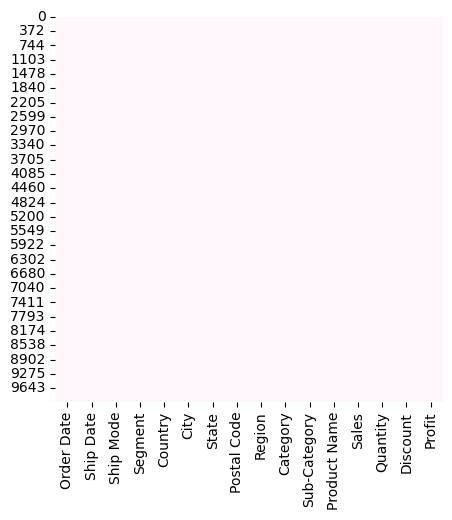

In [ ]:
df_no_outliers.describe()
df_no_outliers.info()
plt.figure(figsize=(5,5))
sns.heatmap(df_no_outliers.isnull(), cbar=False, cmap='PuBu')
plt.show()

In [ ]:
categorical, contin=[],[]

for i in df_no_outliers.columns:
    
    if df_no_outliers[i].dtype == 'object':
        categorical.append(i)
    else:
        contin.append(i)
        
print(categorical)
print(contin)

['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category', 'Product Name']
['Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit']


In [ ]:
df_no_outliers["Order Date"] = pd.to_datetime(df_no_outliers["Order Date"] )
df_no_outliers["Ship Date"] = pd.to_datetime(df_no_outliers["Ship Date"] )

In [ ]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7874 entries, 0 to 9992
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    7874 non-null   datetime64[ns]
 1   Ship Date     7874 non-null   datetime64[ns]
 2   Ship Mode     7874 non-null   object        
 3   Segment       7874 non-null   object        
 4   Country       7874 non-null   object        
 5   City          7874 non-null   object        
 6   State         7874 non-null   object        
 7   Postal Code   7874 non-null   int64         
 8   Region        7874 non-null   object        
 9   Category      7874 non-null   object        
 10  Sub-Category  7874 non-null   object        
 11  Product Name  7874 non-null   object        
 12  Sales         7874 non-null   float64       
 13  Quantity      7874 non-null   int64         
 14  Discount      7874 non-null   float64       
 15  Profit        7874 non-null   float64      

## Correlation Analysis

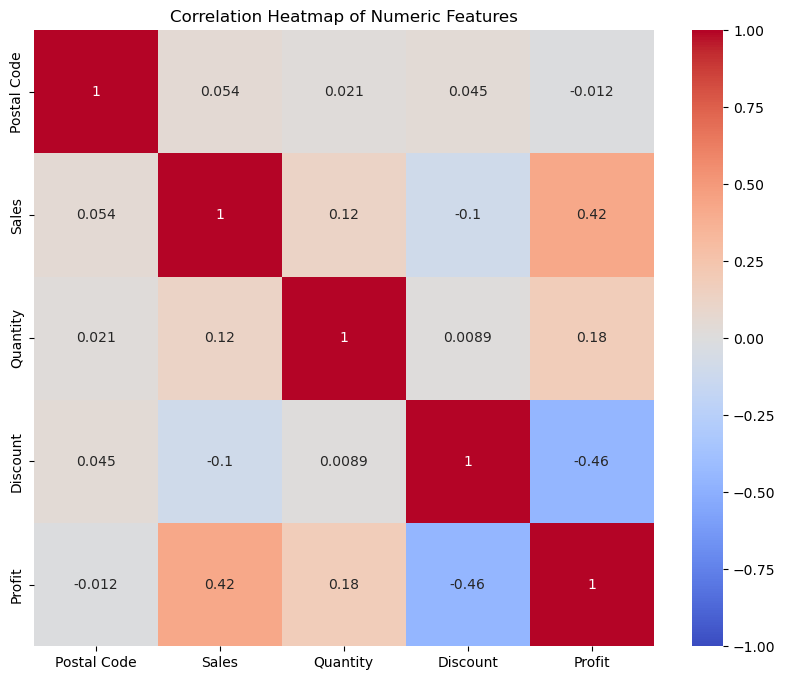

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_no_outliers[contin].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## Encode Categorical Variables

In [ ]:
df_no_outliers[contin] = StandardScaler().fit_transform(df_no_outliers[contin])
dataset_original = dataset.copy()
dataset_original[contin] = StandardScaler().fit_transform(dataset_original[contin])

In [ ]:
label_encoder = LabelEncoder()

for column in df_no_outliers.select_dtypes(include=['object']).columns:
    df_no_outliers[column] = label_encoder.fit_transform(df_no_outliers[column])
    dataset_original[column] = label_encoder.fit_transform(dataset_original[column])
    

In [ ]:
df_no_outliers

,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,2016-11-08,2016-11-11,2,0,0,190,15,-0.414391,2,0,4,358,2.122423,-0.733214,-0.741029,1.717204
2,2016-06-12,2016-06-16,2,1,0,259,3,1.068641,3,1,10,1267,-0.622711,-0.733214,-0.741029,-0.240105
4,2015-10-11,2015-10-18,3,0,0,149,8,-0.698097,2,1,14,517,-0.536719,-0.733214,0.260037,-0.483357
5,2014-06-09,2014-06-14,3,0,0,259,3,1.068516,3,0,9,514,-0.242694,1.695001,-0.741029,0.167530
6,2014-06-09,2014-06-14,3,0,0,259,3,1.068516,3,1,2,994,-0.704175,0.238072,-0.741029,-0.514123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,2017-11-17,2017-11-21,3,1,0,20,9,-0.782377,2,2,13,1084,1.502454,0.723715,-0.741029,2.484294
9989,2014-01-21,2014-01-23,2,0,0,288,8,-0.702177,2,0,9,1407,-0.504755,-0.247571,0.260037,-0.394748
9990,2017-02-26,2017-03-03,3,0,0,100,3,1.149339,3,0,9,1360,0.235657,-0.733214,-0.741029,0.249292
9991,2017-02-26,2017-03-03,3,0,0,100,3,1.149339,3,2,13,41,2.084866,-0.733214,0.260037,0.459310


# Model Building and Selection

## Experiment with df_no_outliers Data

In [ ]:
# Re-splitting the original data (no scaling or feature engineering)
X_no_outliers = df_no_outliers.drop(columns=['Discount', "Order Date", "Ship Date"]).values
y_no_outliers = df_no_outliers['Discount'].values

X_original = dataset_original.drop(columns=['Discount', "Order Date", "Ship Date"]).values
y_original = dataset_original['Discount'].values

In [63]:
X_train_standed, X_test_standed, y_train_standed, y_test_standed = train_test_split(X_no_outliers, y_no_outliers, random_state=42, test_size=0.2)


In [64]:
from sklearn.metrics import mean_absolute_error

        
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R^2 Score": r2, "y_pred":y_pred}

In [70]:
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge




# Baseline models to test on the raw data
baseline_models = {
    "RandomForestRegressor": RandomForestRegressor(n_estimators=50, criterion='squared_error', max_depth=4, random_state = 10),
    "XGBRegressor":  XGBRegressor(learning_rate=0.1,max_depth=7,n_estimators=200, n_components=0.95),
    "LGBMRegressor":  lgb.LGBMRegressor(num_leaves=50, max_depth=3, learning_rate=0.2, n_estimators=50, random_state=10),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "CatBoostRegressor":  CatBoostRegressor (iterations=100, learning_rate=0.1, depth =4, random_state = 10, verbose=False),
    
}



RandomForestRegressor - 
CV RMSE: 0.3792, 
Test MAE: 0.2780, 
Test MSE: 0.1426, 
Test RMSE: 0.3776, 
R^2 Score: 0.8598


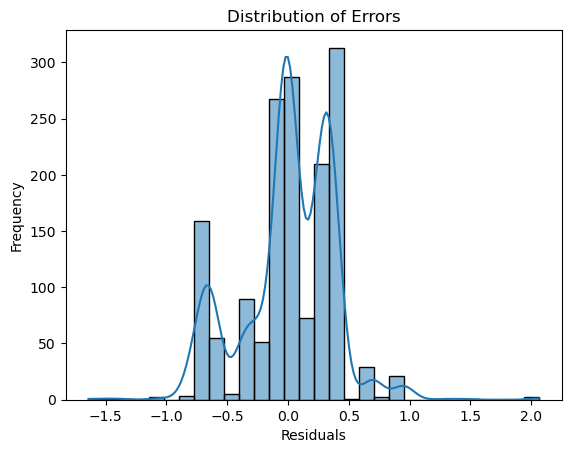

XGBRegressor - 
CV RMSE: 0.0704, 
Test MAE: 0.0187, 
Test MSE: 0.0061, 
Test RMSE: 0.0780, 
R^2 Score: 0.9940


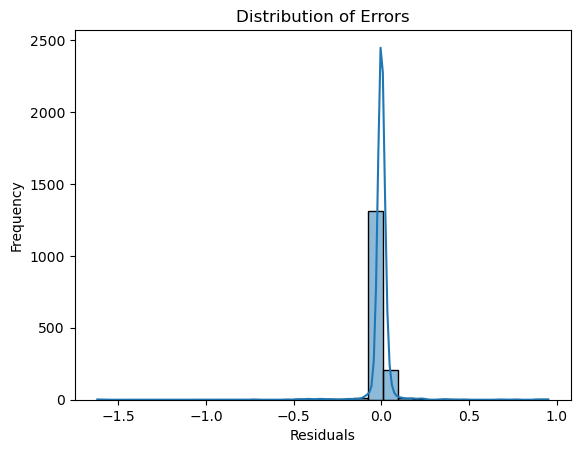

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 6299, number of used features: 12
[LightGBM] [Info] Start training from score 0.002174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

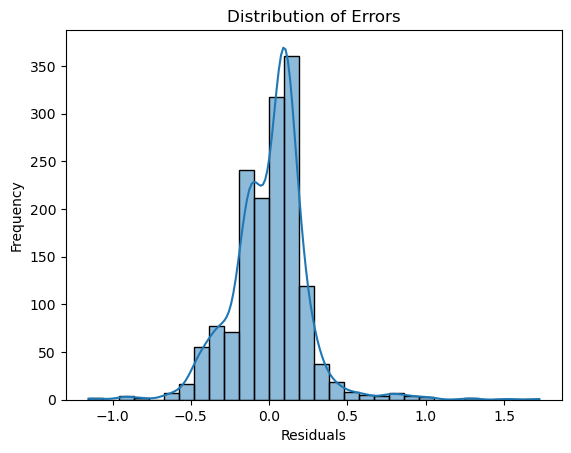

Ridge Regression - 
CV RMSE: 0.9084, 
Test MAE: 0.6212, 
Test MSE: 0.6835, 
Test RMSE: 0.8268, 
R^2 Score: 0.3278


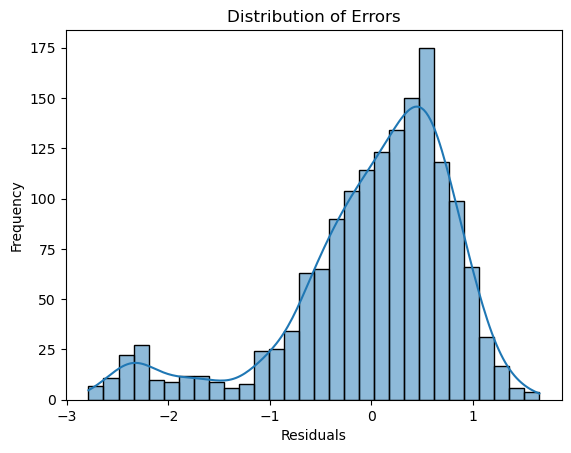

Lasso Regression - 
CV RMSE: 0.9734, 
Test MAE: 0.6941, 
Test MSE: 0.9554, 
Test RMSE: 0.9775, 
R^2 Score: 0.0605


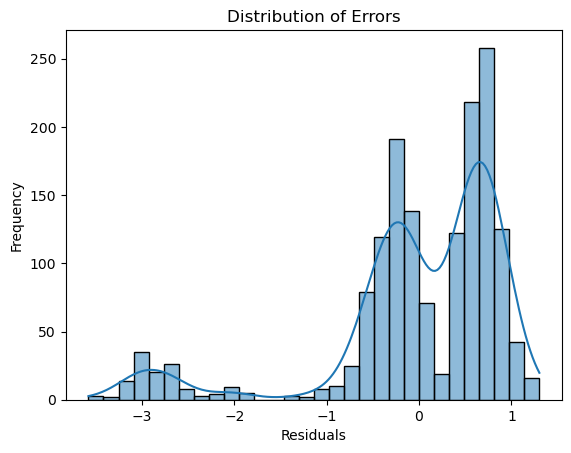

CatBoostRegressor - 
CV RMSE: 0.2674, 
Test MAE: 0.1901, 
Test MSE: 0.0630, 
Test RMSE: 0.2510, 
R^2 Score: 0.9380


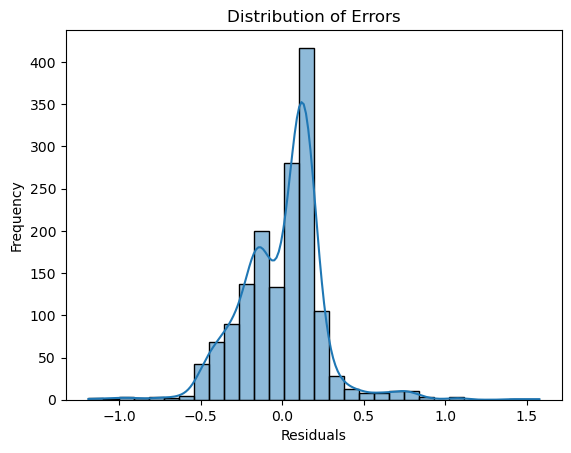

In [71]:
from sklearn.model_selection import cross_val_score


cv_results = {}
for model_name, model in baseline_models.items():

    model.fit(X_train_standed, y_train_standed)
    y_pred = model.predict(X_test_standed)
    residuals = (y_pred - y_test_standed)
    # Cross-validation
    cv_scores = cross_val_score(model, X_original, y_original, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores).mean()  # RMSE from cross-validation
    
    # Test-set evaluation using our custom evaluation function
    test_metrics = evaluate_model(model, X_train_standed, X_test_standed, y_train_standed, y_test_standed)
    
    cv_results[model_name] = {
        "Cross-Validation RMSE": cv_rmse,
        "Test Set Evaluation": test_metrics
    }
    

    print(f"{model_name} - \nCV RMSE: {cv_rmse:.4f}, \nTest MAE: {test_metrics['MAE']:.4f}, "
          f"\nTest MSE: {test_metrics['MSE']:.4f}, \nTest RMSE: {test_metrics['RMSE']:.4f}, "
          f"\nR^2 Score: {test_metrics['R^2 Score']:.4f}")
    
    sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Errors')
    plt.show()    

    print("=============================================================")

#original

RandomForestRegressor - 
CV RMSE: 0.3792, 
Test MAE: 0.2704, 
Test MSE: 0.1400, 
Test RMSE: 0.3742, 
R^2 Score: 0.8584

XGBRegressor - 
CV RMSE: 0.3547, 
Test MAE: 0.2968, 
Test MSE: 0.1290, 
Test RMSE: 0.3592, 
R^2 Score: 0.8695

LGBMRegressor - 
CV RMSE: 0.2452, 
Test MAE: 0.1888, 
Test MSE: 0.0638, 
Test RMSE: 0.2526, 
R^2 Score: 0.9354

Ridge Regression - 
CV RMSE: 0.9084, 
Test MAE: 0.6606, 
Test MSE: 0.8186, 
Test RMSE: 0.9047, 
R^2 Score: 0.1719

Lasso Regression - 
CV RMSE: 0.9734, 
Test MAE: 0.7019, 
Test MSE: 0.9339, 
Test RMSE: 0.9664, 
R^2 Score: 0.0551

CatBoostRegressor - 
CV RMSE: 0.2674, 
Test MAE: 0.2077, 
Test MSE: 0.0705, 
Test RMSE: 0.2655, 
R^2 Score: 0.9287

#no_outliers

RandomForestRegressor - 
CV RMSE: 0.3792, 
Test MAE: 0.2780, 
Test MSE: 0.1426, 
Test RMSE: 0.3776, 
R^2 Score: 0.8598

XGBRegressor - 
CV RMSE: 0.3547, 
Test MAE: 0.2694, 
Test MSE: 0.1144, 
Test RMSE: 0.3382, 
R^2 Score: 0.8875

LGBMRegressor - 
CV RMSE: 0.2452, 
Test MAE: 0.1740, 
Test MSE: 0.0579, 
Test RMSE: 0.2406, 
R^2 Score: 0.9431

Ridge Regression - 
CV RMSE: 0.9084, 
Test MAE: 0.6212, 
Test MSE: 0.6835, 
Test RMSE: 0.8268, 
R^2 Score: 0.3278

Lasso Regression - 
CV RMSE: 0.9734, 
Test MAE: 0.6941, 
Test MSE: 0.9554, 
Test RMSE: 0.9775, 
R^2 Score: 0.0605

CatBoostRegressor - 
CV RMSE: 0.2674, 
Test MAE: 0.1901, 
Test MSE: 0.0630, 
Test RMSE: 0.2510, 
R^2 Score: 0.9380

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# Define the MLP model for regression
sequential = Sequential()
sequential.add(Dense(64, input_dim=X_train_standed.shape[1], activation='relu'))  # First hidden layer
sequential.add(Dense(32, activation='relu'))                               # Second hidden layer
sequential.add(Dense(1, activation='linear'))                              # Output layer

# Compile the model
sequential.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
sequential.fit(X_train_standed, y_train_standed, epochs=100, batch_size=10, validation_split=0.2)


Epoch 1/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5016.5830 - val_loss: 2.5227
Epoch 2/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - loss: 1.9045 - val_loss: 1.9674
Epoch 3/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - loss: 1.4208 - val_loss: 1.7936
Epoch 4/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - loss: 1.3897 - val_loss: 1.2768
Epoch 5/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - loss: 1.3044 - val_loss: 1.3482
Epoch 6/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - loss: 1.3554 - val_loss: 1.6297
Epoch 7/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - loss: 1.7965 - val_loss: 1.1830
Epoch 8/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - loss: 2.2267 - val_loss: 4.4778
Epoch 9/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - loss: 2.1788 - val_loss: 4.6114
Epoch 10/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - loss: 2.5629 - val_loss: 5.9701
Epoch 11/100
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - loss: 2.6648 - val_loss: 5.0545
Epoch 12/100
640/6

In [67]:
y_pred = sequential.predict(X_test_standed)
r2_scoree = r2_score(y_test_standed, y_pred)
print(r2_scoree)
residuals = y_pred - y_test_standed


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.3034214385448718
